In [ ]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import colors
from time import sleep
from scipy.special import softmax

rg = np.random.RandomState(42)


In [ ]:

def row_col_to_seq(row_col, num_cols):  #Converts row_column to state number format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts state to row column format
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.done=False
        self.steps=0
        self.max_steps=100

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def render(self,state, render_agent=False, ax=None):
        grid = np.zeros((self.num_rows, self.num_cols), dtype=int)

        for goal in self.goal_states:
            grid[goal[0], goal[1]] = 4

        if self.bad_states is not None:
            for bad_state in self.bad_states:
                grid[bad_state[0], bad_state[1]] = 3

        if self.obs_states is not None:
            for obs_state in self.obs_states:
                grid[obs_state[0], obs_state[1]] = 2

        if self.restart_states is not None:
            for restart_state in self.restart_states:

                grid[restart_state[0], restart_state[1]]=6

        if render_agent:
            grid[state[0][0],state[0][1]] = 5

        plt.clf()

        if not render_agent:
            cmap = plt.cm.colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23'])
        else:
            cmap = plt.cm.colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00','#808080'])

        if ax is None:
            fig, ax = plt.subplots()

        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)

    def plot_Q(self, Q, message="Q plot"):
        plt.figure(figsize=(10, 10))
        plt.title(message)
        plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar()

        def x_direct(a):
            if a in [0, 1]:
                return 0
            return 1 if a == 3 else -1

        def y_direct(a):
            if a in [3, 2]:
                return 0
            return -1 if a == 0 else 1

        policy = Q.argmax(-1)
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel() + 0.5, idx[0].ravel() + 0.5, policyx.ravel(), policyy.ravel(), pivot="middle",
                color='red')
        plt.show()




    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state
    


    def reset(self):
      self.done=False
      self.steps=0
      return int(self.start_state_seq)
      

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break
        self.steps+=1

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if next_next in self.goal_states_seq or self.steps>=self.max_steps:
              self.done=True
          else:
              self.done=False
          
          return next_next, self.R[next_next]
          
        else:
          if next_state in self.goal_states_seq or self.steps>=self.max_steps:
              self.done=True
          else:
              self.done=False
          return next_state, self.R[next_state]


In [ ]:
def generate_world(wind,p_good_transition,start_state):
# specify world parameters
  wind=wind
  p_good_transition=p_good_transition
  start_state=np.array([start_state])

  num_cols = 10
  num_rows = 10
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                          [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                          [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                          [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  #start_state = np.array([[0,4]])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create model

  gw = GridWorld(num_rows=num_rows,
                  num_cols=num_cols,
                  start_state=start_state,
                  goal_states=goal_states, wind = False)
  gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                  goal_reward=10,
                  bad_state_reward=-6,
                  restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=1,
                                  bias=0.5)
  env = gw.create_gridworld()
  return env

def visualizing_env(env):
  print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
  print("Number of states", env.num_states)
  print("start state", env.start_state_seq)
  print("goal state(s)", env.goal_states_seq)
  env.P[0,:,0]
  env.render(state=env.start_state,ax=plt,render_agent=True) # red = obstructions, green= goal states, blue= bad states, yellow= start state, grey= restart state,


# Defining the Action Selection Policies 



# Epsilon greedy
def choose_action_epsilon(env,Q, state, epsilon, rg=rg):
    actions=np.arange(env.num_actions)
    if not Q[state[0][0], state[0][1]].any() or rg.rand()<epsilon:
        return rg.choice(actions)
    else:
        return np.argmax(Q[state[0][0],state[0][1]])

# Softmax
def choose_action_softmax(env,Q, state, tau=1, rg=rg):
    actions = np.arange(env.num_actions)
    state_rowcol=seq_to_col_row(state, env.num_cols)
    q_values = Q[state_rowcol[0][0], state_rowcol[0][1]]
    
    # Apply softmax with temperature tau
    probabilities = softmax(q_values / tau)
    
    # Choose action based on probabilities
    chosen_action = rg.choice(actions, 1, p=probabilities)[0]
    
    return chosen_action


In [ ]:

# SARSA with Softmax

print_freq = 100

def sarsa_s(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    #print(alpha,epsilon,gamma,tau)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,tau)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,tau)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1], action_next] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1
       

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts

def best_policy(env,Q):

    state = env.reset()
    done = False
    steps = 0
    tot_reward = 0
    while not env.done:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        state_row_cols= seq_to_col_row(state, env.num_cols)
        env.render(state_row_cols,ax=plt, render_agent=True)
        plt.show()
        steps += 1
        state, reward = env.step(state,Q[state_row_cols[0][0],state_row_cols[0][1]].argmax())
        tot_reward += reward
        sleep(0.2)
    print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


def qlearning_s(env, Q, gamma = 1, plot_heat = False, choose_action = choose_action_softmax,epsilon0=0.1,alpha0=0.3,tau=0.2):
  
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,tau)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1],np.argmax(Q[state_next_rowcol[0][0],state_next_rowcol[0][1]])] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            tot_reward += reward
            steps += 1
            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts






In [ ]:
# sarsa with epsilon greedy 

def sarsa_e(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_epsilon,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,epsilon)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,epsilon)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1], action_next] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1
       

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts
    



# Q-Learning with epsilon-greedy

def qlearning_e(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_epsilon,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,epsilon)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,epsilon)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1],np.argmax(Q[state_next_rowcol[0][0],state_next_rowcol[0][1]])] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            tot_reward += reward
            steps += 1
            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
            
    return Q, episode_rewards, steps_to_completion,state_visit_counts



In [30]:
def plot_all(func,env):
    env=env
    num_expts = 5
    reward_avgs, steps_avgs = [], []
    rewards_all,steps_all=[],[]
    mean_rewd=[]
    Q_all= np.zeros((env.num_rows, env.num_cols, env.num_actions))
    state_visits_all= np.zeros((env.num_rows, env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        rg = np.random.RandomState(i)
        Q, rewards, steps,state_visits = func(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax,epsilon0=epsilon0,alpha0=alpha0,tau=tau)
        rewards_all.append(rewards)
        mean_rewd.append(np.mean(rewards))
        steps_all.append(steps)
        Q_all=Q_all+Q
        state_visits_all+=state_visits

    Q_avg=Q_all/num_expts
    state_visits_avg=state_visits_all/num_expts
    reward_avgs.append(np.mean(rewards_all,axis=0))
    steps_avgs.append(np.mean(steps_all,axis=0))
    mean_steps=np.mean(steps_all)
    mean_rewards=np.mean(mean_rewd)

    env.plot_Q(Q_avg)

    episodes_no=np.arange(episodes)
    reward_stds = np.std(rewards_all, axis=0)
    steps_stds = np.std(steps_all, axis=0)
    # plt.figure()
    # plt.errorbar(episodes_no, steps_avgs[0], yerr=steps_stds, label='Mean Steps', fmt='-o', ecolor='skyblue')
    # #plt.plot(episodes_no,steps_avgs[0])
    # plt.xlabel('Episode')
    # plt.ylabel('Number of steps to Goal')
    # plt.show()

    # plt.figure()
    # plt.errorbar(episodes_no, reward_avgs[0], yerr=reward_stds, label='Mean Reward', fmt='-o', ecolor='skyblue')
    # #plt.plot(episodes_no,reward_avgs[0])
    # plt.xlabel('Episode')
    # plt.ylabel('Total Reward')
    # plt.show()

    # plt.figure()
    # plt.imshow(state_visits_avg, cmap='Blues', interpolation='nearest',origin='lower')
    # plt.title('State Visit Counts Heatmap')
    # plt.colorbar(label='Visit Counts')
    # plt.xlabel('Column Index')
    # plt.ylabel('Row Index')
    # plt.grid(True, linestyle='--', alpha=0.5, color='black') 
    # plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Mean Steps
    axes[0].errorbar(episodes_no[1000:], steps_avgs[0][1000:], yerr=steps_stds[1000:], label='Mean Steps', fmt='-o', ecolor='skyblue')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Number of steps to Goal')
    axes[0].set_title('Mean Steps')

    # Plot Mean Reward
    axes[1].errorbar(episodes_no[1000:], reward_avgs[0][1000:], yerr=reward_stds[1000:], label='Mean Reward', fmt='-o', ecolor='skyblue')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Total Reward')
    axes[1].set_title('Mean Reward')

    # Plot State Visit Counts Heatmap
    heatmap = axes[2].imshow(state_visits_avg, cmap='Blues', interpolation='nearest', origin='lower')
    axes[2].set_title('State Visit Counts Heatmap')
    axes[2].set_xlabel('Column Index')
    axes[2].set_ylabel('Row Index')
    axes[2].grid(True, linestyle='--', alpha=0.5, color='black') 
    fig.colorbar(heatmap, ax=axes[2], label='Visit Counts')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

    print('Average reward across all the runs = ',mean_rewards)
    print('Average steps across all the runs = ',mean_steps)

In [ ]:
def opt_all(func,env,individual):
    env=env
    num_expts = 5
    alpha, gamma, epsilon, tau = individual['alpha'], individual['gamma'], individual['epsilon'], individual['tau']
    reward_avgs, steps_avgs = [], []
    rewards_all,steps_all=[],[]
    mean_rewd=[]
    #print(alpha,gamma,epsilon,tau)
    Q_all= np.zeros((env.num_rows, env.num_cols, env.num_actions))
    state_visits_all= np.zeros((env.num_rows, env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        rg = np.random.RandomState(i)
        Q, rewards, steps,state_visits = func(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax,epsilon0=epsilon,alpha0=alpha,tau=tau)
        rewards_all.append(rewards)
        mean_rewd.append(np.mean(rewards))
        steps_all.append(steps)
        Q_all=Q_all+Q
        state_visits_all+=state_visits

    Q_avg=Q_all/num_expts
    state_visits_avg=state_visits_all/num_expts
    reward_avgs.append(np.mean(rewards_all,axis=0))
    steps_avgs.append(np.mean(steps_all,axis=0))
    mean_steps=np.mean(steps_all)
    mean_rewards=np.mean(mean_rewd)
    return mean_rewards,mean_steps

In [ ]:
env1= generate_world(False,1,[0,4])
env2= generate_world(False,1,[3,6])
env3= generate_world(False,0.7,[0,4])
env4= generate_world(False,0.7,[3,6])
env5= generate_world(True,1,[0,4])
env6= generate_world(True,1,[3,6])

In [ ]:
visualizing_env(env1)
# Defining parameters for the experiment
alpha0 = 0.4555424713669709
gamma = 0.9885680108923366
episodes = 5000
epsilon0 = 0.1
tau=0.5240787302486811

plot_all(sarsa_s,env1)
# plot_all(sarsa_e,env1)
# plot_all(qlearning_s,env1)
# plot_all(qlearning_e,env1)

In [ ]:

def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        individual = {
            'alpha': np.random.uniform(0.3, 0.5),
            'gamma': np.random.uniform(0.9, 1.0),
            'epsilon': np.random.uniform(0.05, 0.3),
            'tau': np.random.uniform(0.5,0.8)
        }
        population.append(individual)
    return population

def evaluate_individual(individual, env, func):
    alpha, gamma, epsilon, tau = individual['alpha'], individual['gamma'], individual['epsilon'], individual['tau']
    #print(alpha,gamma, epsilon, tau)
    mean_rewards, mean_steps = opt_all(func, env,individual)
    return mean_rewards, mean_steps

def select_parents(population, num_parents):
    # Select top individuals based on their fitness
    sorted_population = sorted(population, key=lambda x: (x['mean_rewards'], -x['mean_steps']), reverse=True)
    return sorted_population[:num_parents]

def crossover(parent1, parent2):
    # Perform crossover to create a new individual
    crossover_point = np.random.choice(list(parent1.keys()))
    child = {key: parent1[key] if np.random.rand() < 0.5 else parent2[key] for key in parent1.keys()}
    return child

def mutate(individual, mutation_rate=0.05):
    # Perform mutation on an individual
    for key in individual.keys():
        if np.random.rand() < mutation_rate:
            if key == 'tau':
                individual[key] = np.random.uniform(0.6,1.5)
            else:
                individual[key] = np.random.uniform(0.0, 1.0)
    return individual

def genetic_algorithm(env, func, population_size=10, num_generations=5, num_parents=4):
    # Initialize population
    population = initialize_population(population_size)
    print(population)

    # Evolution loop
    for generation in range(num_generations):
        print(f"\nGeneration {generation + 1}")
        for individual in population:
            # Evaluate fitness of each individual
            mean_rewards, mean_steps = evaluate_individual(individual, env, func)
            individual['mean_rewards'] = mean_rewards
            individual['mean_steps'] = mean_steps

        # Select parents
        parents = select_parents(population, num_parents)

        # Create next generation
        new_population = parents.copy()
        while len(new_population) < population_size:
            parent1, parent2 = np.random.choice(parents, size=2, replace=False)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        # Update population for the next generation
        population = new_population

    # Get the best individual from the final generation
    best_individual = max(population, key=lambda x: (x['mean_rewards'], -x['mean_steps']))
    best_hyperparameters = {key: best_individual[key] for key in ['alpha', 'gamma', 'epsilon', 'tau']}
    best_mean_rewards, best_mean_steps = best_individual['mean_rewards'], best_individual['mean_steps']

    return best_hyperparameters, best_mean_rewards, best_mean_steps


In [ ]:


best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env1,sarsa_s)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")


In [ ]:
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

In [ ]:
best_hyperparameters, best_mean_rewards, best_mean_steps = genetic_algorithm(env1,sarsa_e)
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

In [ ]:
# visualizing_env(env2)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env2)
# plot_all(sarsa_e,env2)
# plot_all(qlearning_s,env2)
# plot_all(qlearning_e,env2)

In [ ]:
print(f"\nBest Hyperparameters: {best_hyperparameters}")
print(f"Best Mean Rewards: {best_mean_rewards}")
print(f"Best Mean Steps: {best_mean_steps}")

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 273.87it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:16<00:00, 298.65it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 417.85it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:13<00:00, 382.51it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:14<00:00, 348.15it/s]


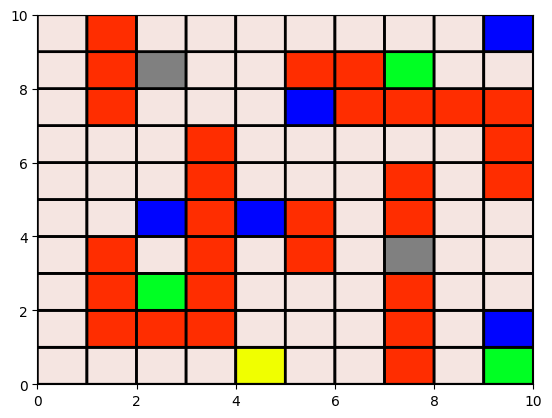

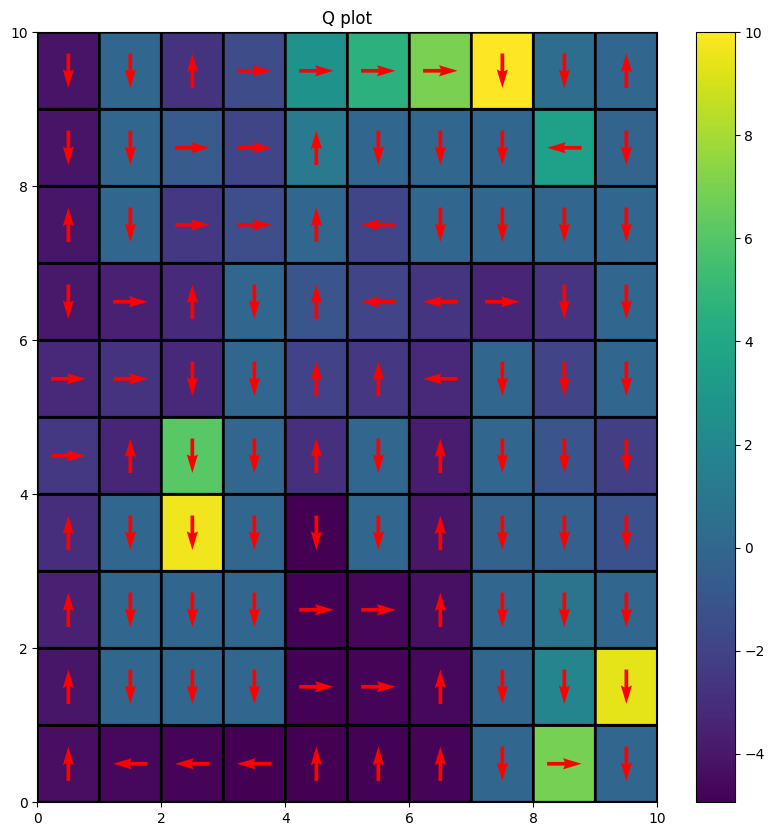

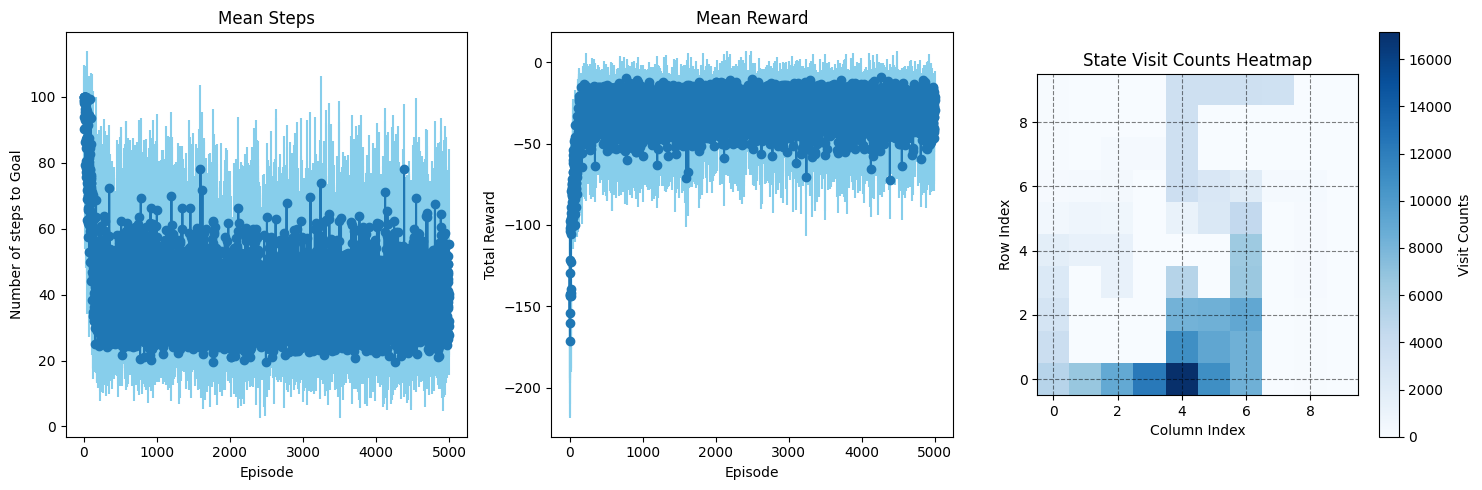

Average reward across all the runs =  -30.456920000000004
Average steps across all the runs =  39.67668


In [24]:
alpha0=0.4543905467640020
gamma=0.8

visualizing_env(env1)
# Defining parameters for the experiment
episodes = 5000
epsilon0 = 0.4
tau=0.5240787302486811

plot_all(sarsa_e,env1)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]
Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:06<00:00, 789.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 658.22it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1077.27it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:04<00:00, 1037.53it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:04<00:00, 1043.11it/s]


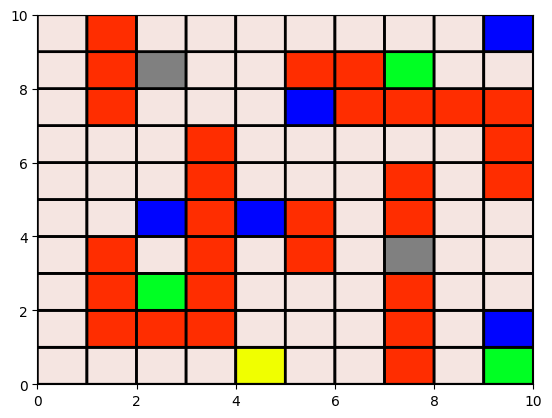

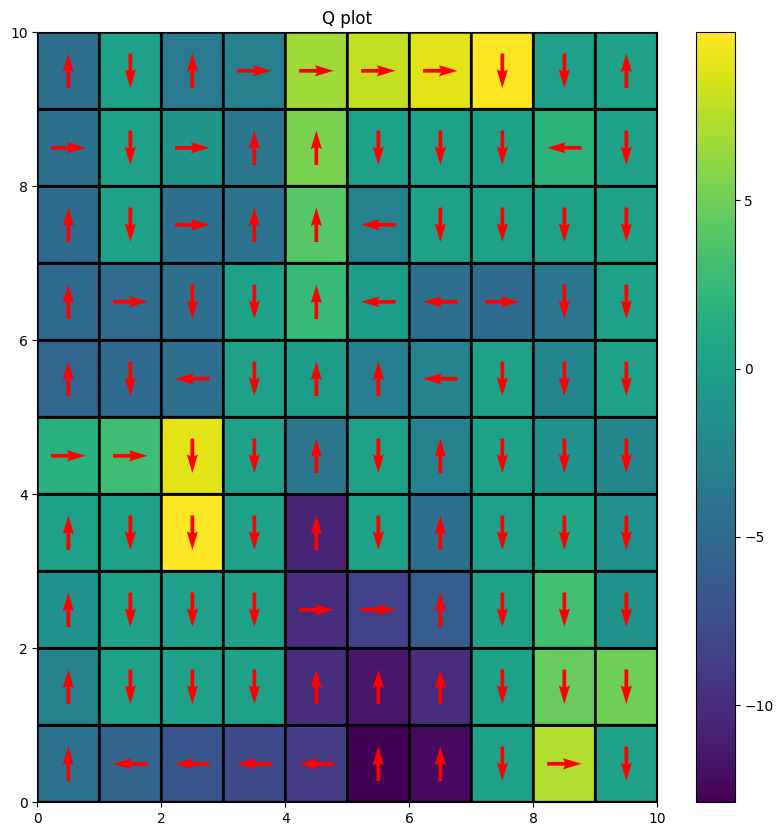

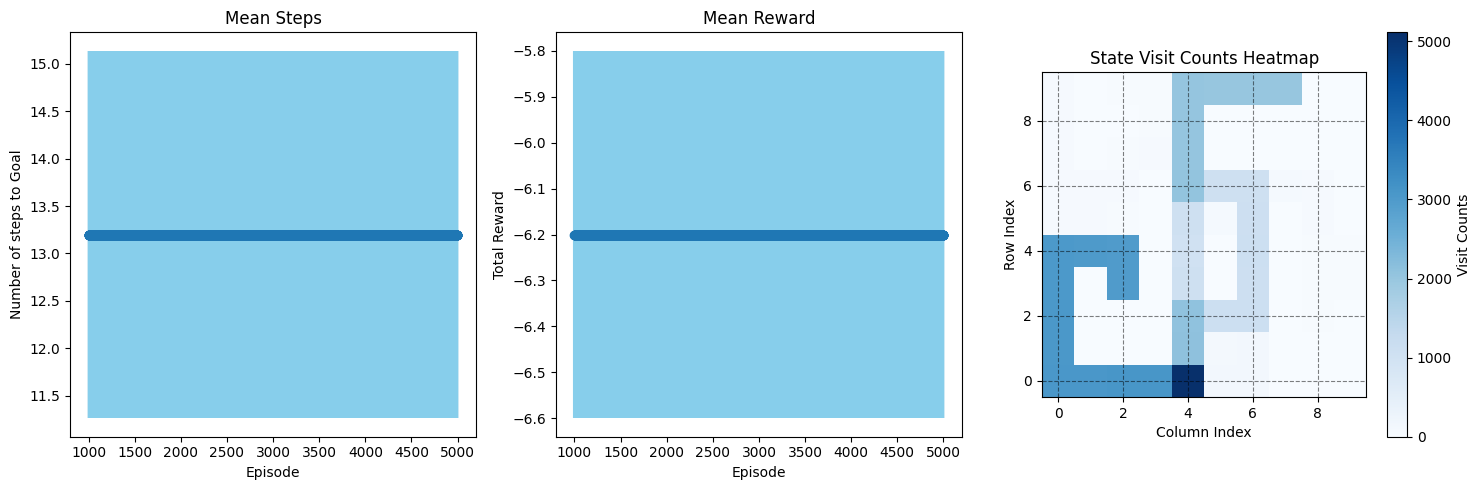

Average reward across all the runs =  -6.96464
Average steps across all the runs =  13.822


In [32]:
alpha0=0.4543905467640020
gamma=1

visualizing_env(env1)
# Defining parameters for the experiment
episodes = 5000
epsilon0 = 0.4
tau=0.5240787302486811

plot_all(sarsa_e,env1)

In [ ]:
# visualizing_env(env3)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env3)
# plot_all(sarsa_e,env3)
# plot_all(qlearning_s,env3)
# plot_all(qlearning_e,env3)

In [ ]:
# visualizing_env(env4)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env4)
# plot_all(sarsa_e,env4)
# plot_all(qlearning_s,env4)
# plot_all(qlearning_e,env4)

In [ ]:
# visualizing_env(env5)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env5)
# plot_all(sarsa_e,env5)
# plot_all(qlearning_s,env5)
# plot_all(qlearning_e,env5)

In [ ]:
# visualizing_env(env6)
# # Defining parameters for the experiment
# alpha0 = 0.4
# gamma = 0.9
# episodes = 1000
# epsilon0 = 0.1
# tau=1

# plot_all(sarsa_s,env6)
# plot_all(sarsa_e,env6)
# plot_all(qlearning_s,env6)
# plot_all(qlearning_e,env6)